<!---
The MIT License (MIT)

Copyright (c) 2016 Sean UN Wood

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
--->

# Blind Speech Separation with GCC-NMF: Demo

#### Sean UN Wood, September 2016

## Abstract

This **iPython Notebook** is a demo of GCC-NMF blind source separation algorithm, combining:
 - Non-negative matrix factorization (NMF): *unsupervised dictionary learning algorithm*
 - Generalized cross-correlation (GCC): *source localization method*

Separation is performed directly on the stereo mixture signal using no additional data:
- An NMF dictionary is first learned from the left and right mixture spectrograms, concatenated *in time*.
- Dictionary atoms are then attributed to individual sources *over time* according to their time difference of arrival (TDOA) estimates, defining a binary coefficient mask for each source. 
- Masked coefficients are then used to reconstruct each source independently.

This demo separates the speech sources from the *data/dev1_female3_liverec_130ms_1m_mix.wav* mixture, taken from the [SiSEC 2016 Underdetermined speech mixtures](https://sisec.inria.fr/home/2016-underdetermined-speech-and-music-mixtures/) "dev1" dataset, and saves results to the *data* directory.

## Overview
1. Preliminary setup
2. Input mixture signal
3. Complex mixture spectrogram
4. GCC-PHAT source localization
5. NMF decomposition
6. GCC-NMF coefficient mask generation
7. Source spectrogram estimates reconstruction
8. Source signal estimates reconstruction

# 1. Preliminary setup
#### Python imports

In [1]:
from gccNMF.gccNMFFunctions import *
from gccNMF.gccNMFPlotting import *

from IPython import display

%matplotlib inline

#### Parameter definitions

In [2]:
# Preprocessing params
windowSize = 1024
fftSize = windowSize
hopSize = 128
windowFunction = hanning

# TDOA params
numTDOAs = 128

# NMF params
dictionarySize = 128
numIterations = 100
sparsityAlpha = 0

# Input params    
mixtureFileNamePrefix = '../data/dev1_female3_liverec_130ms_1m'
microphoneSeparationInMetres = 1.0
numSources = 3

# 2. Input mixture signal

#### Load mixture signal from the wav file

In [3]:
mixtureFileName = getMixtureFileName(mixtureFileNamePrefix)
stereoSamples, sampleRate = loadMixtureSignal(mixtureFileName)

numChannels, numSamples = stereoSamples.shape
durationInSeconds = numSamples / float(sampleRate)

#### Plot mixture signal

Input mixture signal:
	sampleRate: 16000 samples/sec
	numChannels: 2
	numSamples: 160000
	dtype: float32
	duration: 10.00 seconds


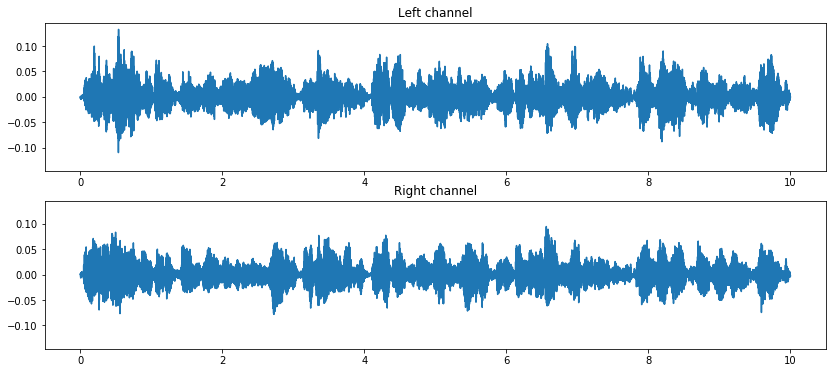

In [4]:
describeMixtureSignal(stereoSamples, sampleRate)

figure(figsize=(14, 6))
plotMixtureSignal(stereoSamples, sampleRate)

display.display( display.Audio(mixtureFileName) )

# 3. Complex mixture spectrogram

#### Compute complex mixture spectrograms from input signal with an STFT

In [5]:
complexMixtureSpectrogram = computeComplexMixtureSpectrogram( stereoSamples, windowSize,
                                                              hopSize, windowFunction ) 
numChannels, numFrequencies, numTime = complexMixtureSpectrogram.shape
frequenciesInHz = getFrequenciesInHz(sampleRate, numFrequencies)
frequenciesInkHz = frequenciesInHz / 1000.0

#### Plot magnitude mixture spectrograms

STFT:
	windowSize: 1024
	hopSize: 128
	windowFunction: <function hanning at 0x10435ee18>
	complexMixtureSpectrogram.shape = (numChannels, numFreq, numWindows): (2, 513, 1243)
	complexMixtureSpectrogram.dtype = complex64


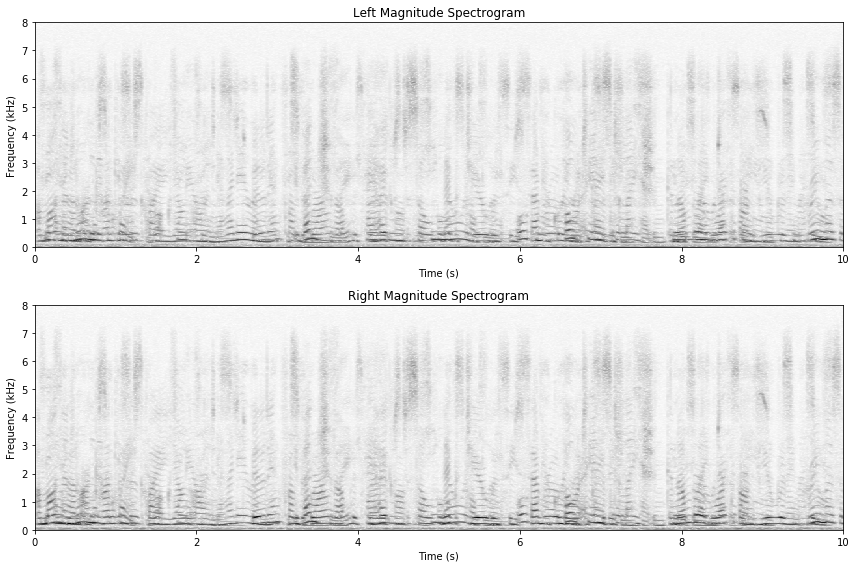

In [6]:
describeMixtureSpectrograms(windowSize, hopSize, windowFunction, complexMixtureSpectrogram)

figure(figsize=(12, 8))
plotMixtureSpectrograms(complexMixtureSpectrogram, frequenciesInkHz, durationInSeconds)

# 4. Perform source localization with GCC-PHAT

#### Localize target TDOA indexes

In [7]:
spectralCoherenceV = complexMixtureSpectrogram[0] * complexMixtureSpectrogram[1].conj() \
                     / abs(complexMixtureSpectrogram[0]) / abs(complexMixtureSpectrogram[1])
angularSpectrogram = getAngularSpectrogram( spectralCoherenceV, frequenciesInHz,
                                            microphoneSeparationInMetres, numTDOAs )
meanAngularSpectrum = mean(angularSpectrogram, axis=-1) 
targetTDOAIndexes = estimateTargetTDOAIndexesFromAngularSpectrum( meanAngularSpectrum,
                                                                  microphoneSeparationInMetres,
                                                                  numTDOAs, numSources)

#### Plot target localization

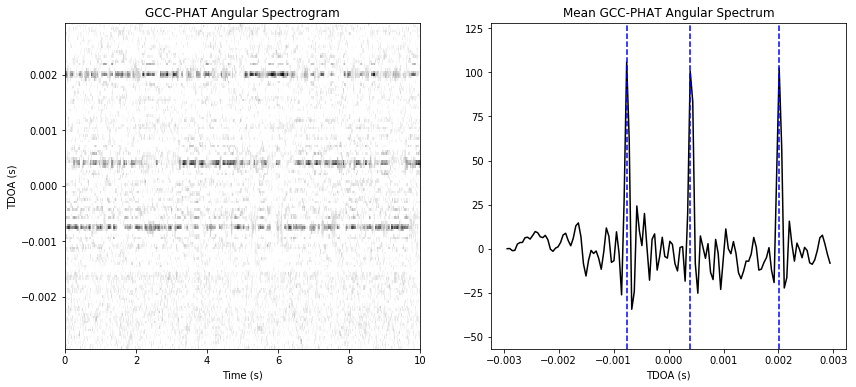

In [8]:
figure(figsize=(14, 6))
plotGCCPHATLocalization( spectralCoherenceV, angularSpectrogram, meanAngularSpectrum,
                         targetTDOAIndexes, microphoneSeparationInMetres, numTDOAs,
                         durationInSeconds )

# 5. Perform NMF decomposition of mixture spectrograms

#### Compute NMF decomposition, with left and right magnitude spectrograms concatenated *in time*

In [9]:
V = concatenate( abs(complexMixtureSpectrogram), axis=-1 )
W, H = performKLNMF(V, dictionarySize, numIterations, sparsityAlpha)

numChannels = stereoSamples.shape[0]
stereoH = array( hsplit(H, numChannels) )

#### Plot NMF decomposition

Input V:
    V.shape = (numFreq, numWindows): (513, 2486)
    V.dtype = float32
Dictionary W:
    W.shape = (numFreq, numAtoms): (513, 128)
    W.dtype = float32
Coefficients H:
    H.shape = (numAtoms, numWindows): (128, 2486)
    H.dtype = float32


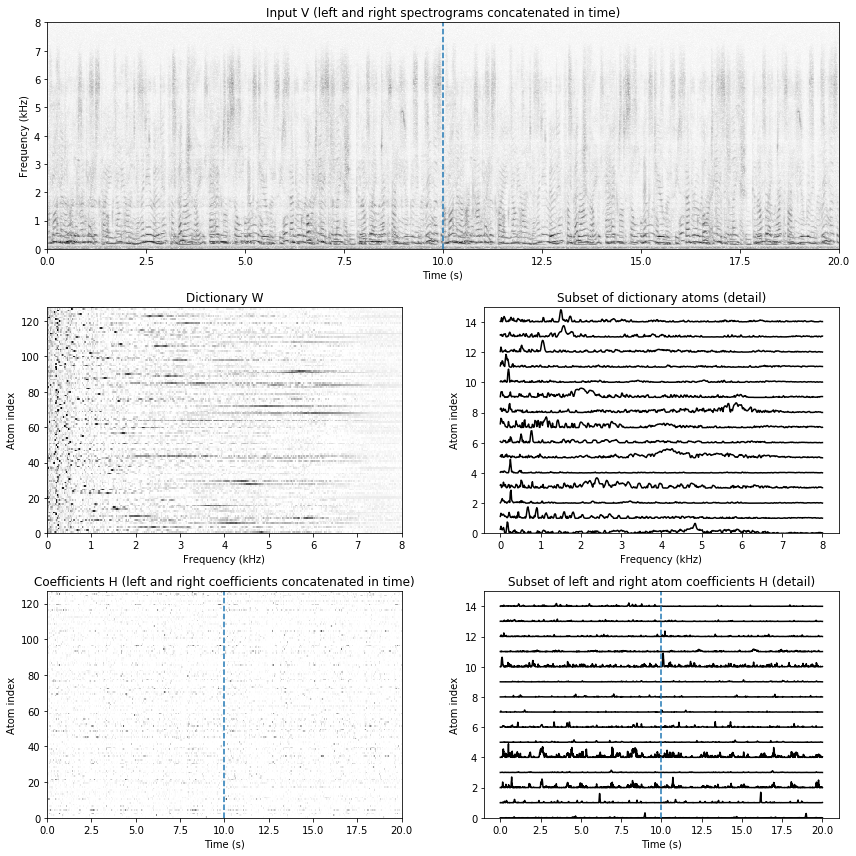

In [10]:
describeNMFDecomposition(V, W, H)

figure(figsize=(12, 12))
plotNMFDecomposition(V, W, H, frequenciesInkHz, durationInSeconds, numAtomsToPlot=15)

# 6. Compute GCC-NMF target coefficient masks

#### Compute NMF coefficient masks for each target

In [11]:
targetTDOAGCCNMFs = getTargetTDOAGCCNMFs( spectralCoherenceV, microphoneSeparationInMetres,
                                          numTDOAs, frequenciesInHz, targetTDOAIndexes, W,
                                          stereoH )
targetCoefficientMasks = getTargetCoefficientMasks(targetTDOAGCCNMFs, numSources)

#### Plot NMF coefficient masks for each target, and resulting masked coefficients for each channel

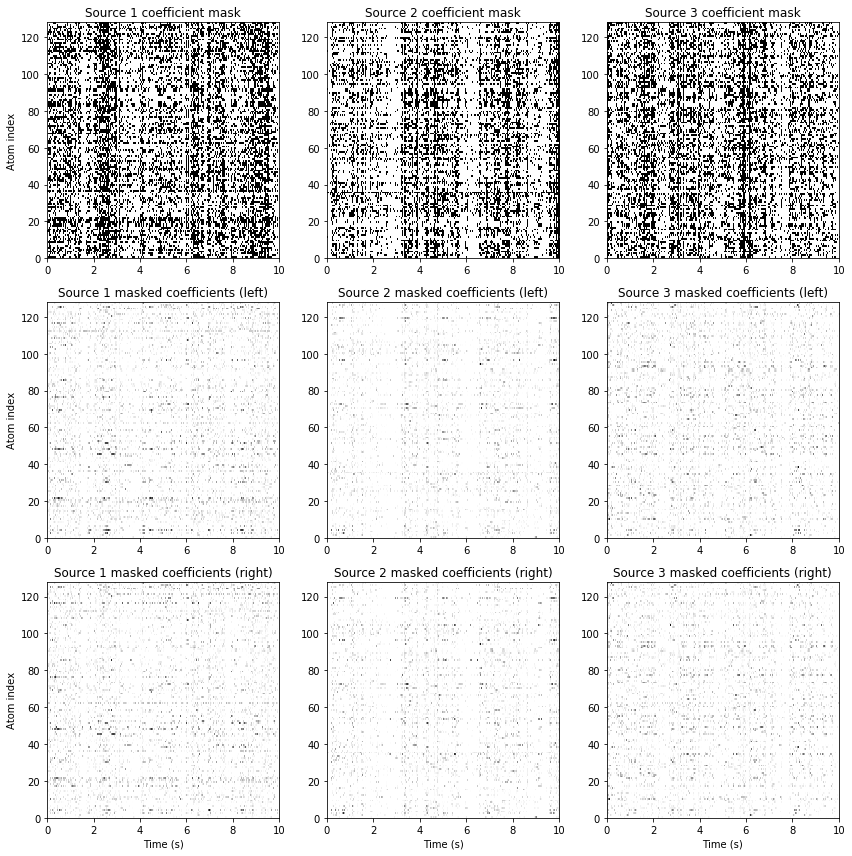

In [12]:
figure(figsize=(12, 12))
plotCoefficientMasks(targetCoefficientMasks, stereoH, durationInSeconds)

# 7. Reconstruct source spectrogram estimates

#### Reconstruct source spectrogram estimates using masked NMF coefficients for each target, and each channel

In [13]:
targetSpectrogramEstimates = getTargetSpectrogramEstimates( targetCoefficientMasks,
                                                            complexMixtureSpectrogram, W,
                                                            stereoH )

#### Plot reconstructed source estimate spectrograms

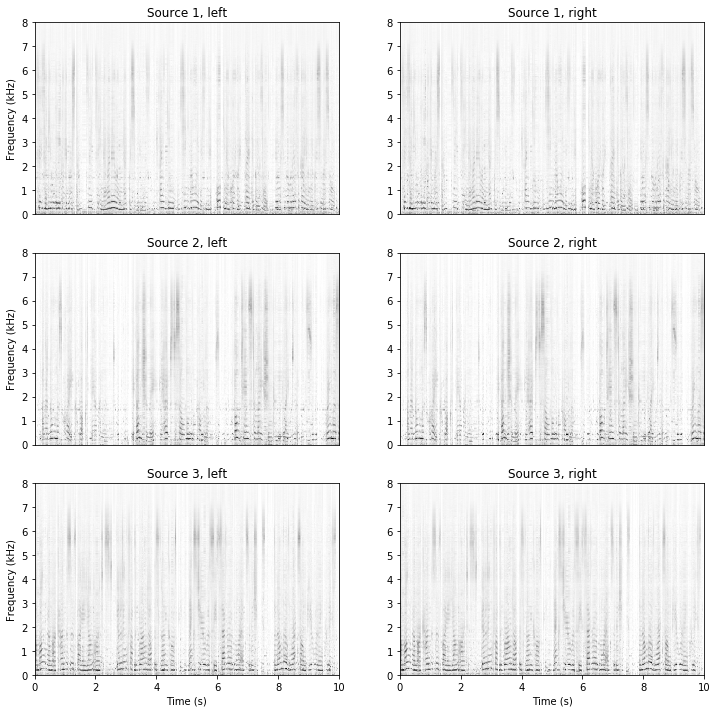

In [14]:
figure(figsize=(12, 12))
plotTargetSpectrogramEstimates(targetSpectrogramEstimates, durationInSeconds, frequenciesInkHz)

# 8. Reconstruct time domain target signal estimates

#### Combine source estimate spectrograms with the input mixture spectrogram's phase, and perform the inverse STFT

In [15]:
targetSignalEstimates = getTargetSignalEstimates( targetSpectrogramEstimates, windowSize,
                                                  hopSize, windowFunction )
saveTargetSignalEstimates(targetSignalEstimates, sampleRate, mixtureFileNamePrefix)

#### Plot time domain source signal estimates

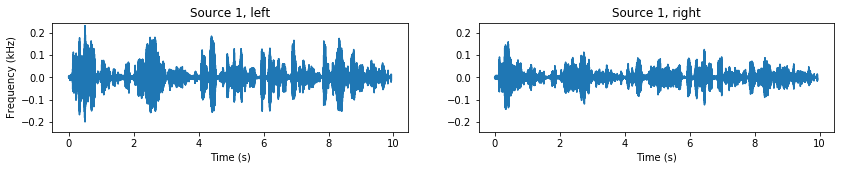

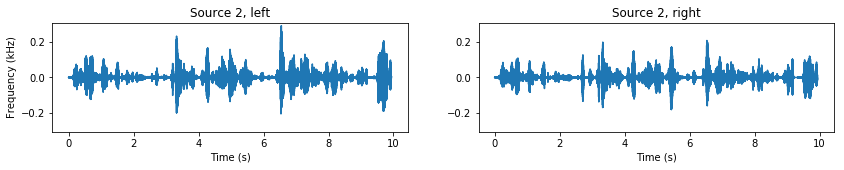

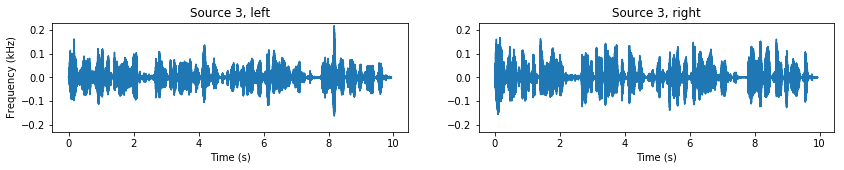

In [16]:
for sourceIndex in range(numSources):
    figure(figsize=(14, 2))
    fileName = getSourceEstimateFileName(mixtureFileNamePrefix, sourceIndex)
    plotTargetSignalEstimate( targetSignalEstimates[sourceIndex], sampleRate,
                              'Source %d' % (sourceIndex+1) )
    display.display(display.Audio(fileName))